In [1]:
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!, addcov!, multcov!
import Proj4
using Optim
using Distances
;

In [2]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data Import and Preprocessing

In [3]:
include("iowa.jl")
iowa = prepare_iowa_data(data_dir);

# `sumprod` sum of products kernel

In [34]:
k1 = fix(Periodic(log(1.0),log(3.0),log(24.0)), :lp)
k2 = RQIso(log(0.5),0.0,0.0)  # half an hour
k3 = RQIso(log(2.0),0.0,0.0)  # two hours
k4 = RQIso(log(12.0),0.0,0.0) # twelve hours

ksp1 = fix(SEIso(log(5e4), log(1.0)), :lσ)
ksp2 = fix(SEIso(log(5e4), log(1.0)), :lσ)
ksp3 = fix(SEIso(log(5e4), log(1.0)), :lσ)
ksp4 = fix(SEIso(log(5e4), log(1.0)), :lσ)
k_means = SEIso(log(1), log(10.0))

k_spatiotemporal = Masked(k1, [1]) * Masked(ksp1, [2,3]) +
                 Masked(k2, [1])  * Masked(ksp2, [2,3]) +
                 Masked(k3, [1]) * Masked(ksp3, [2,3]) +
                 Masked(k4, [1])  * Masked(ksp4, [2,3]) +
                 fix(Masked(k_means, [2,3]))
;

# optimize

In [35]:
@time opt_out = optim_kernel(k_spatiotemporal, 0.0, iowa[:isdSubset], iowa[:hourly_data], :Optim);

Base.LinAlg.PosDefException(13)
Base.LinAlg.PosDefException(26)
20067.068842 seconds (150.96 M allocations: 2.074 TiB, 2.00% gc time)


In [36]:
opt_out[:mll]

-45944.57896898338

In [37]:
print(opt_out[:hyp])

[-1.72543, -0.210693, 1.00448, 13.5739, -1.22027, -0.715922, -1.07356, 9.27737, 0.654045, -0.0667558, 0.126885, 10.9934, 2.18318, 1.47688, -1.14017, 12.8225]

In [38]:
opt_out[:opt_out]

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.0,0.0, ...]
 * Minimizer: [-1.7254304808355303,-0.21069301640061977, ...]
 * Minimum: 4.594458e+04
 * Iterations: 272
 * Convergence: true
   * |x - x'| ≤ 1.0e-05: false 
     |x - x'| = 3.52e-05 
   * |f(x) - f(x')| ≤ 1.0e-10 |f(x)|: true
     |f(x) - f(x')| = 9.23e-11 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 3.58e-01 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 560
 * Gradient Calls: 289

In [42]:
print("k₁: Periodic \n=================\n")
@printf("σ: %5.3f\n", √k1.kern.σ2)
@printf("l: %5.3f\n", √k1.kern.ℓ2)
@printf("p: %5.0f hours\n", k1.kern.p)
print("> spatial decay:\n")
@printf("l: %5.3f km\n", √ksp1.kern.ℓ2 / 1000)
print("\nk₂: RQIso \n=================\n")
@printf("σ: %5.3f\n", √k2.σ2)
@printf("l: %5.3f hours\n", √ k2.ℓ2)
@printf("α: %5.3f\n", k2.α)
print("> spatial decay:\n")
# @printf("σ: %5.3f\n", √ksp2.σ2)
@printf("l: %5.3f km\n", √ksp2.kern.ℓ2 / 1000)
print("\nk₃: SEIso \n=================\n")
@printf("σ: %5.3f\n", √k3.σ2)
@printf("l: %5.3f hours\n", √k3.ℓ2)
print("> spatial decay:\n")
# @printf("σ: %5.3f\n", √ksp3.σ2)
@printf("l: %5.3f km\n", √ksp3.kern.ℓ2 / 1000)
print("\nk₄: RQIso \n=================\n")
@printf("σ: %5.3f\n", √k4.σ2)
@printf("l: %5.3f days\n", √k4.ℓ2 / 24)
@printf("α: %5.3f\n",  k4.α)
print("> spatial decay:\n")
# @printf("σ: %5.3f\n", √ksp4.σ2)
@printf("l: %5.3f km\n", √ksp4.kern.ℓ2 / 1000)
print("\n=================\n")
@printf("σy: %5.3f\n", exp(opt_out[:hyp][1]))

k₁: Periodic 
σ: 2.730
l: 0.810
p:    24 hours
> spatial decay:
l: 785.323 km

k₂: RQIso 
σ: 0.489
l: 0.295 hours
α: 0.342
> spatial decay:
l: 10.693 km

k₃: SEIso 
σ: 0.935
l: 1.923 hours
> spatial decay:
l: 59.481 km

k₄: RQIso 
σ: 4.379
l: 0.370 days
α: 0.320
> spatial decay:
l: 370.458 km

σy: 0.178


# Plotting fitted variogram

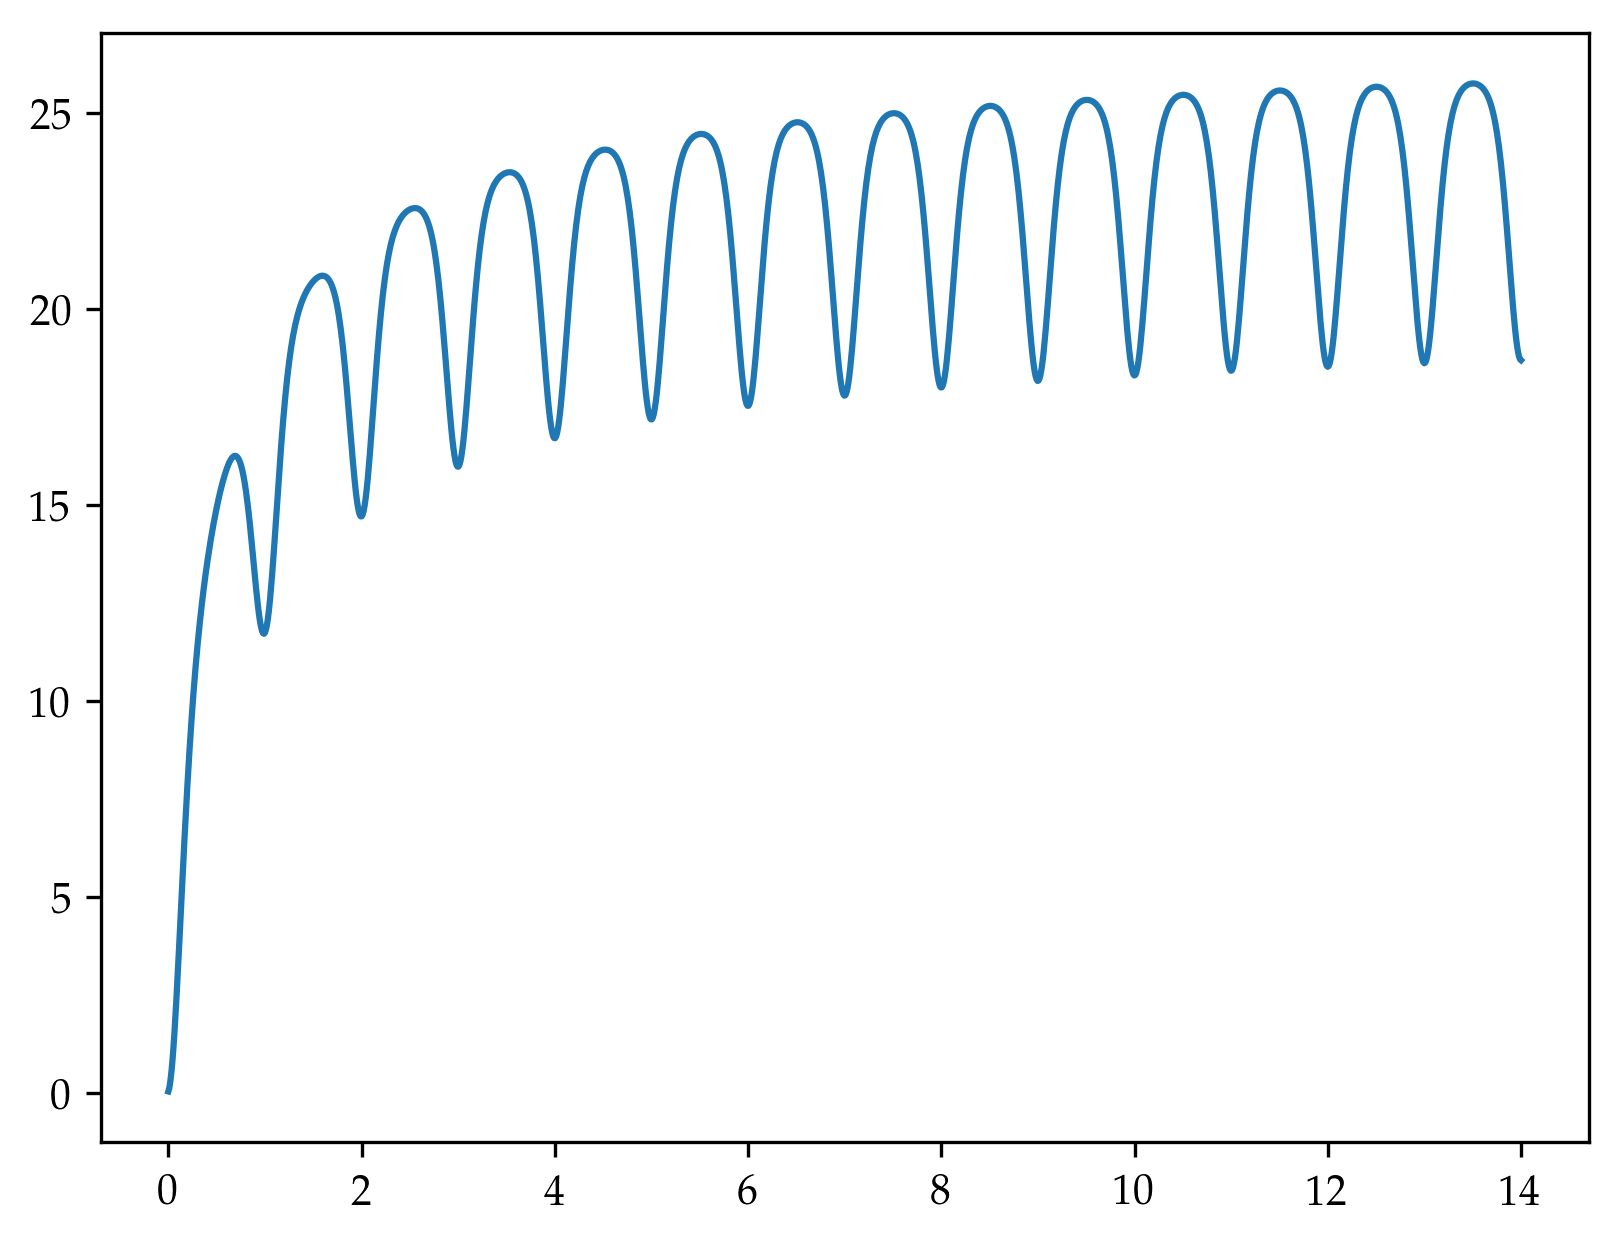

In [44]:
σ2_y = exp(2*opt_out[:hyp][1])
rr = linspace(0.0, 24*14, 24*14*4)
ck_r = [cov(k_spatiotemporal, [0.0,0.0,0.0], [r,0.0,0.0]) for r in rr]
plt.plot(rr/24.0, σ2_y + ck_r[1].-ck_r, label="fitted variogram")
;